# Упражнения <a id='tasks'></a>

Необходимо изучить библиотеку [tslearn](https://tslearn.readthedocs.io/en/stable/).

1. Взять выбранные для лабы 14 набор(ы) данных. 

3. Попробовать все методы классификации и регрессии, описанные в блоноте 14 aeon:
    Distance-based 
    Свертки (модели семейства Rocket и Hydra)
    Feature-based
    Deep Learning

    Для каждого подхода обучть не менее 3х разных моделей для классификации и регрессии.
    
     
    

In [1]:
# ============================================================
# Coffee dataset 
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from aeon.datasets import load_classification


X_train_raw, y_train_raw = load_classification("Coffee", split="train")
X_test_raw, y_test_raw = load_classification("Coffee", split="test")

# Преобразование формата: (n_samples, n_channels, series_length) → (n_samples, series_length, n_channels)
X_train = np.moveaxis(X_train_raw, 1, -1)  # tslearn expects (n, sz, d)
X_test = np.moveaxis(X_test_raw, 1, -1)

In [2]:
# Кодирование меток
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Классы: {le.classes_}")

Train: (28, 286, 1), Test: (28, 286, 1)
Классы: ['0' '1']


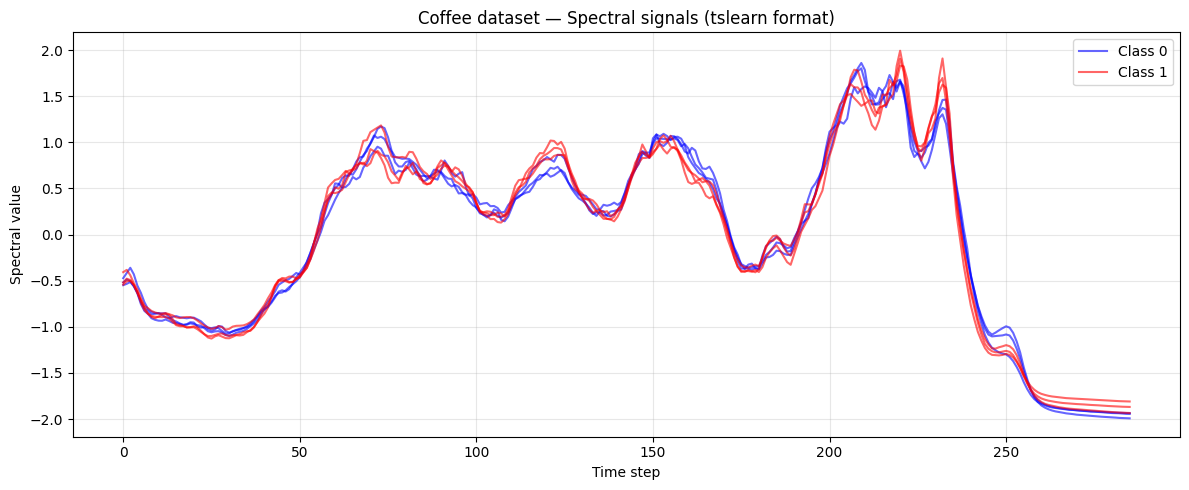

In [3]:
def plot_coffee_tslearn(X, y, title="Coffee dataset"):
    plt.figure(figsize=(12, 5))
    classes = np.unique(y)
    colors = ['blue', 'red']
    
    for idx, cls in enumerate(classes):
        indices = np.where(y == cls)[0][:3]
        for i in indices:
            plt.plot(X[i, :, 0], color=colors[idx], alpha=0.6, 
                    label=f"Class {le.classes_[cls]}" if i == indices[0] else "")
    
    plt.title(title)
    plt.xlabel("Time step")
    plt.ylabel("Spectral value")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_coffee_tslearn(X_train, y_train, "Coffee dataset — Spectral signals (tslearn format)")


results = {"Model": [], "Accuracy": [], "Type": []}

In [5]:

from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.barycenters import dtw_barycenter_averaging
# kNN с DTW
for k in [1, 3, 5]:
    clf = KNeighborsTimeSeriesClassifier(
        n_neighbors=k,
        metric="dtw",
        metric_params={"sakoe_chiba_radius": 10}
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    results["Model"].append(f"kNN-DTW (k={k})")
    results["Accuracy"].append(acc)
    results["Type"].append("Distance-based")
    print(f"   kNN-DTW (k={k}) → Accuracy: {acc:.3f}")

#  kNN с Soft-DTW
clf_softdtw = KNeighborsTimeSeriesClassifier(
    n_neighbors=3,
    metric="softdtw",
    metric_params={"gamma": 0.1}
)
clf_softdtw.fit(X_train, y_train)
y_pred = clf_softdtw.predict(X_test)
acc = accuracy_score(y_test, y_pred)

results["Model"].append("kNN-SoftDTW")
results["Accuracy"].append(acc)
results["Type"].append("Distance-based")
print(f"   kNN-SoftDTW → Accuracy: {acc:.3f}")

#  kNN с Euclidean
clf_euc = KNeighborsTimeSeriesClassifier(
    n_neighbors=3,
    metric="euclidean"
)
clf_euc.fit(X_train, y_train)
y_pred = clf_euc.predict(X_test)
acc = accuracy_score(y_test, y_pred)

results["Model"].append("kNN-Euclidean")
results["Accuracy"].append(acc)
results["Type"].append("Distance-based")
print(f"   kNN-Euclidean → Accuracy: {acc:.3f}")

   kNN-DTW (k=1) → Accuracy: 1.000
   kNN-DTW (k=3) → Accuracy: 1.000
   kNN-DTW (k=5) → Accuracy: 0.929
   kNN-SoftDTW → Accuracy: 1.000
   kNN-Euclidean → Accuracy: 1.000


In [8]:
#  FEATURE-BASED (через извлечение признаков)
from tslearn.neighbors import KNeighborsTimeSeriesClassifier, KNeighborsTimeSeriesRegressor
from tslearn.svm import TimeSeriesSVC, TimeSeriesSVR
# from tslearn.neural_network import TSCNN, ResNetClassifier
from tslearn.clustering import TimeSeriesKMeans, KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from tslearn.metrics import dtw, cdist_dtw, soft_dtw
from tslearn.utils import to_time_series_dataset
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC


In [9]:


# Извлечение статистических признаков
def extract_features(X):
    """Простое извлечение признаков из временных рядов"""
    features = []
    for series in X:
        s = series[:, 0]  # берём первый канал
        feats = [
            np.mean(s), np.std(s), np.min(s), np.max(s),
            np.percentile(s, 25), np.percentile(s, 75),
            np.mean(np.diff(s)),  # средняя производная
            np.std(np.diff(s)),    # волатильность производной
        ]
        features.append(feats)
    return np.array(features)

X_train_feat = extract_features(X_train)
X_test_feat = extract_features(X_test)

# 1. Random Forest на признаках
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_feat, y_train)
y_pred = rf.predict(X_test_feat)
acc = accuracy_score(y_test, y_pred)

results["Model"].append("RF + Handcrafted Features")
results["Accuracy"].append(acc)
results["Type"].append("Feature-based")
print(f"   RF + Features → Accuracy: {acc:.3f}")

# 2. SVM на признаках
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train_feat, y_train)
y_pred = svm.predict(X_test_feat)
acc = accuracy_score(y_test, y_pred)

results["Model"].append("SVM + Handcrafted Features")
results["Accuracy"].append(acc)
results["Type"].append("Feature-based")
print(f"   SVM + Features → Accuracy: {acc:.3f}")

# 3. Gradient Boosting на признаках
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train_feat, y_train)
y_pred = gb.predict(X_test_feat)
acc = accuracy_score(y_test, y_pred)

results["Model"].append("GB + Handcrafted Features")
results["Accuracy"].append(acc)
results["Type"].append("Feature-based")
print(f"   GB + Features → Accuracy: {acc:.3f}")



   RF + Features → Accuracy: 0.964
   SVM + Features → Accuracy: 0.607
   GB + Features → Accuracy: 0.929


In [13]:
# ============================================================
# DEEP LEARNING (через aeon, т.к. tslearn не поддерживает)
# ============================================================

from aeon.classification.deep_learning import (
    InceptionTimeClassifier,
    ResNetClassifier,
    FCNClassifier)
from sklearn.metrics import accuracy_score


# InceptionTime
try:
    inception = InceptionTimeClassifier(
        n_epochs=20,
        batch_size=8,
        random_state=42,
        verbose=False
    )
    inception.fit(X_train_raw, y_train_raw)  # используем исходный формат aeon!
    y_pred = inception.predict(X_test_raw)
    acc = accuracy_score(y_test_raw, y_pred)
    
    results["Model"].append("InceptionTime")
    results["Accuracy"].append(acc)
    results["Type"].append("Deep Learning")
    print(f"InceptionTime → Accuracy: {acc:.3f}")
except Exception as e:
    print(f"InceptionTime error: {e}")

# ResNet
try:
    print(" Training ResNet...")
    resnet = ResNetClassifier(
        n_epochs=20,
        batch_size=8,
        random_state=42,
        verbose=False
    )
    resnet.fit(X_train_raw, y_train_raw)
    y_pred = resnet.predict(X_test_raw)
    acc = accuracy_score(y_test_raw, y_pred)
    
    results["Model"].append("ResNet (aeon)")
    results["Accuracy"].append(acc)
    results["Type"].append("Deep Learning")
    print(f"ResNet → Accuracy: {acc:.3f}")
except Exception as e:
    print(f"ResNet error: {e}")

# FCN (Fully Convolutional Network)
try:
    print("   Training FCN...")
    fcn = FCNClassifier(
        n_epochs=20,
        batch_size=8,
        random_state=42,
        verbose=False
    )
    fcn.fit(X_train_raw, y_train_raw)
    y_pred = fcn.predict(X_test_raw)
    acc = accuracy_score(y_test_raw, y_pred)
    
    results["Model"].append("FCN")
    results["Accuracy"].append(acc)
    results["Type"].append("Deep Learning")
    print(f"FCN → Accuracy: {acc:.3f}")
except Exception as e:
    print(f"FCN error: {e}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000029085FD4220> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
InceptionTime → Accuracy: 0.536
 Training Res


RESULTS — Coffee Dataset (tslearn)
                     Model  Accuracy           Type
             kNN-DTW (k=1)  1.000000 Distance-based
             kNN-DTW (k=3)  1.000000 Distance-based
               kNN-SoftDTW  1.000000 Distance-based
             kNN-Euclidean  1.000000 Distance-based
 RF + Handcrafted Features  0.964286  Feature-based
             kNN-DTW (k=5)  0.928571 Distance-based
 GB + Handcrafted Features  0.928571  Feature-based
SVM + Handcrafted Features  0.607143  Feature-based
             InceptionTime  0.535714  Deep Learning
                       FCN  0.535714  Deep Learning
             ResNet (aeon)  0.464286  Deep Learning


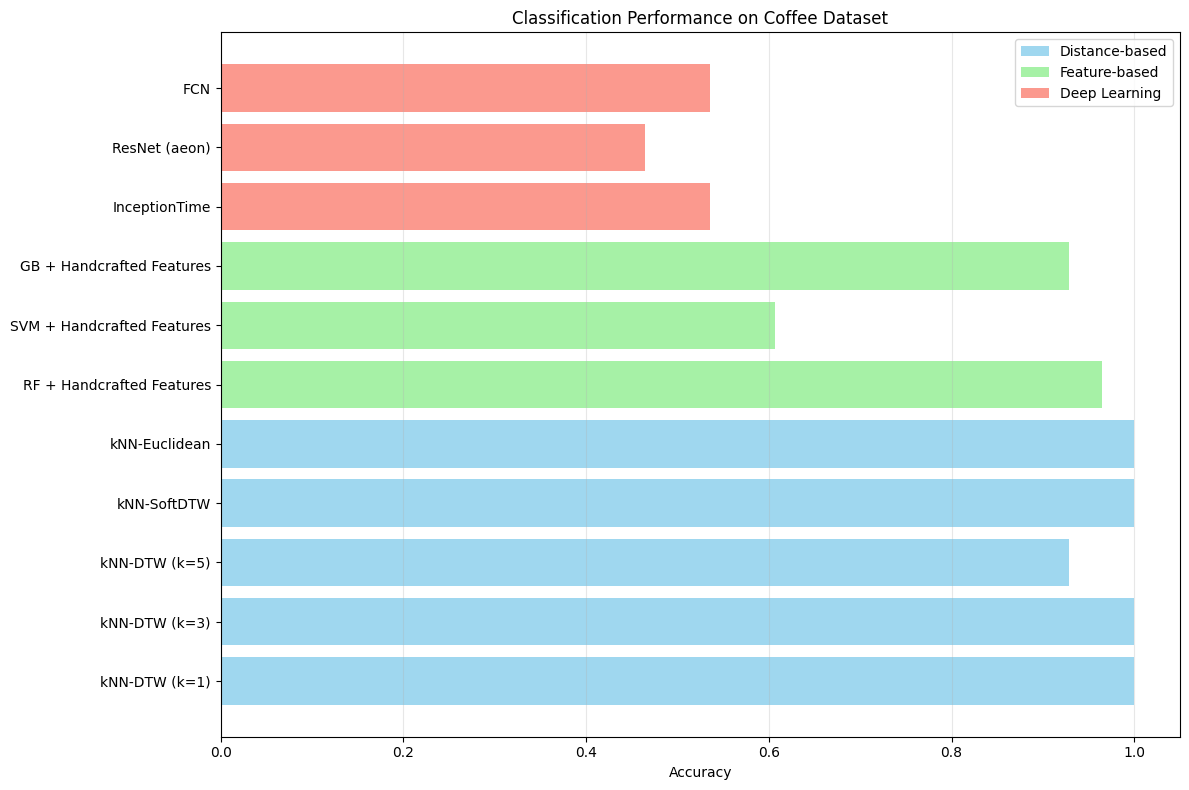

1. tslearn не содержит Rocket/Hydra — они есть только в aeon/sktime
2. Для Rocket-подобных методов в tslearn можно использовать:
 - tslearn.feature_extraction.FeatureExtractor с кастомными функциями
 - Или комбинировать tslearn + sklearn с ручным извлечением признаков
3. Deep Learning в tslearn требует больше данных — на Coffee может overfit'ить
4. Format: tslearn использует (n_samples, series_length, n_channels)


In [17]:
# результаты
import pandas as pd

print("\n" + "="*70)
print("RESULTS — Coffee Dataset (tslearn)")
print("="*70)

results_df = pd.DataFrame(results)
print(results_df.sort_values("Accuracy", ascending=False).to_string(index=False))

# Визуализация результатов
plt.figure(figsize=(12, 8))
colors = {"Distance-based": "skyblue", "Feature-based": "lightgreen", "Deep Learning": "salmon"}

for method in results_df["Type"].unique():
    subset = results_df[results_df["Type"] == method]
    plt.barh(
        subset["Model"], 
        subset["Accuracy"],
        label=method,
        color=colors.get(method, "gray"),
        alpha=0.8
    )

plt.xlabel("Accuracy")
plt.title("Classification Performance on Coffee Dataset")
plt.legend()
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()



print("1. tslearn не содержит Rocket/Hydra — они есть только в aeon/sktime")
print("2. Для Rocket-подобных методов в tslearn можно использовать:")
print(" - tslearn.feature_extraction.FeatureExtractor с кастомными функциями")
print(" - Или комбинировать tslearn + sklearn с ручным извлечением признаков")
print("3. Deep Learning в tslearn требует больше данных — на Coffee может overfit'ить")
print("4. Format: tslearn использует (n_samples, series_length, n_channels)")
